Author: Mathilde Jay   
Last updated: December 2022.

# Total energy consumed per benchmark as reported by each tools

## Variables and imports


In [2]:
REPOSITORY_DIR = "../../" # TO MODIFY
prefix = [REPOSITORY_DIR + "results/GPU_20_04/", REPOSITORY_DIR + "results/GPU_19_04/"] # ADD AS MANY FOLDER AS YOU NEED
#prefix = [REPOSITORY_DIR + "results/CPU_08_11/"]

In [3]:
import sys
sys.path.append(REPOSITORY_DIR + "code/")

In [4]:
from utils.process_results import add_benchmark_id_to_merged_timeseries, cleaning_table
from utils.tools import convert_energy_kWh_in_joules
import pandas as pd
import matplotlib.pyplot as plt

## Retrieve and merge your data

In [17]:
energy_scope_df = pd.concat([pd.read_csv(file + 'es_ts.csv') for file in prefix]) # if energy scope was part of the experiment
watt_df = pd.concat([pd.read_csv(file + 'g5k_metrics.csv') for file in prefix])
exp_table = pd.concat([pd.read_csv(file + 'processed_table.csv') for file in prefix])

exp_table = cleaning_table(exp_table, watt_df, energy_scope_df)

grouped_watt_df = watt_df.groupby(by=['timestamp_sec']).mean().reset_index()
merged_df = pd.merge(energy_scope_df,grouped_watt_df, on='timestamp_sec', how='outer').sort_values(by=['timestamp_sec'])

merged_df['wattmetre_es_diff'] = abs(merged_df['wattmetre_power_watt'] - merged_df['data.data.etotal(W)'])

b_df = add_benchmark_id_to_merged_timeseries(exp_table, merged_df)

In [18]:
exp_table.columns

Index(['tool_on_one_process', 'experiment_start', 'experiment_end',
       'gpu_0_start_benchmark', 'gpu_0_stop_benchmark',
       'gpu_1_start_benchmark', 'gpu_1_stop_benchmark',
       'gpu_2_start_benchmark', 'gpu_2_stop_benchmark',
       'gpu_3_start_benchmark',
       ...
       'launch_parallel_script', 'trace_tar_file', 'es_trace_id',
       'trace_eprofile', 'error', 'log_dirs', 'tool_PUE',
       'bmc_node_power_watt_energy_consumption(kWh)',
       'wattmetre_power_watt_energy_consumption(kWh)',
       'tool_energy_consumption(kWh)_no_PUE'],
      dtype='object', length=164)

exp_table contains 164 columns describing the experiments (tool, start and stop timestamps of the experiment and each benchmarks, log files, and results).   
Let's check that we have ten experiments for each tool and benchmark:

In [19]:
exp_table[exp_table['tool_on_one_process']==False].groupby(by=['tool_on_one_process', 'tool_name','gpu_0_appli','gpu_0_appli_class']).count()['experiment_start']

tool_on_one_process  tool_name                  gpu_0_appli  gpu_0_appli_class
False                NoTool                     ep           E                    10
                                                idle         sh                   10
                                                lu           D                    10
                                                mg           D                    10
                     carbon_tracker             ep           E                    10
                                                idle         sh                   10
                                                lu           D                    10
                                                mg           D                    10
                     codecarbon                 ep           E                    10
                                                idle         sh                   10
                                                lu           D         

Experiment Impact Tracker estimates the energy at the process level. Idle executions kept leading to a crash. 


## Computing the duration of the experiments

In [20]:
exp_table['benchmark_duration(diff)'] = exp_table['gpu_0_stop_benchmark'] - exp_table['gpu_0_start_benchmark']

In [21]:
exp_table[(exp_table['tool_on_one_process']==False)&(exp_table['tool_name']=='codecarbon')].groupby(by=['gpu_0_appli','gpu_0_appli_class'])[['benchmark_duration(diff)']].mean()

,,benchmark_duration(diff)
gpu_0_appli,gpu_0_appli_class,
ep,E,68.380255
idle,sh,60.003566
lu,D,204.460075
mg,D,155.603518


In [22]:
exp_table[(exp_table['tool_on_one_process']==False)&(exp_table['tool_name']=='codecarbon')].groupby(by=['gpu_0_appli','gpu_0_appli_class'])[['benchmark_duration(diff)']].std()

,,benchmark_duration(diff)
gpu_0_appli,gpu_0_appli_class,
ep,E,0.092619
idle,sh,0.000065
lu,D,0.083162
mg,D,1.347612


The duration of the experiments range between 60 and 200 seconds, and its variation over ten experiments is unsignificant (below 1%).

## Convert energy metrics to Joule

In [23]:
exp_table['wattmetre_power_watt_energy_consumption(joule)'] = exp_table['wattmetre_power_watt_energy_consumption(kWh)'].apply(convert_energy_kWh_in_joules)*10**(-3)
exp_table['bmc_node_power_watt_energy_consumption(joule)'] = exp_table['bmc_node_power_watt_energy_consumption(kWh)'].apply(convert_energy_kWh_in_joules)*10**(-3)
exp_table['tool_energy_consumption(joule)_no_PUE'] = exp_table['tool_energy_consumption(kWh)_no_PUE'].apply(convert_energy_kWh_in_joules)*10**(-3)
exp_table['tool_energy_joule_error'] = (exp_table['wattmetre_power_watt_energy_consumption(joule)'] - exp_table['tool_energy_consumption(joule)_no_PUE'])
exp_table['tool_energy_joule_error_perc'] = (exp_table['wattmetre_power_watt_energy_consumption(joule)'] - exp_table['tool_energy_consumption(joule)_no_PUE'])/exp_table['wattmetre_power_watt_energy_consumption(joule)']

In [24]:
exp_table[exp_table['tool_on_one_process']==False].groupby(by=['tool_name']).agg(['mean','std'])['tool_energy_joule_error_perc']

,mean,std
tool_name,,
NoTool,NaN,NaN
carbon_tracker,0.384368,0.051633
codecarbon,0.195056,0.014620
energy scope,0.308434,0.062682
experiment_impact_tracker,0.442196,0.251787


In [25]:
exp_table['tool_name'].unique()

array(['carbon_tracker', 'codecarbon', 'experiment_impact_tracker',
       'energy scope', 'NoTool'], dtype=object)

## Modify the name so they fit into the graph

In [26]:
plot_df = exp_table.copy()

def modify_tool_name(cell):
    if cell == 'carbon_tracker':
        return 'CT'
    if cell == 'codecarbon':
        return 'CC'
    if cell == 'energy scope':
        return 'ES'
    if cell == 'experiment_impact_tracker':
        return 'EIT'
    if cell == 'NoTool':
        return 'None'

plot_df['tool_name'] = plot_df['tool_name'].apply(modify_tool_name)
plot_df['tool_name']

0        CT
1        CT
2        CT
3        CT
4        CT
       ... 
277      CC
278    None
279    None
280    None
281    None
Name: tool_name, Length: 282, dtype: object

## Add energy calculators to the table
Computations are made in 'online tools.ipynb'.

In [27]:
# CPU benchmarks
to_concat = {
    'External\npower meter':[58014.0, 35114.4, 154180.8, 58014.0, 35114.4, 154180.8], 
    'BMC':[48024.0, 26712.0, 134028.0, 48024.0, 26712.0, 134028.0], 
    'Tool':[22740.0, 13644.0, 56850.0, 13500, 8100, 33750], 
    'Offset':[35274, 21470.4, 97330.8, 44514.0, 27014.4, 120430.8], 
    'tool_name':['GA', 'GA', 'GA', 'MCI', 'MCI', 'MCI'], 
    'gpu_0_appli':['ep', 'lu', 'mg', 'ep', 'lu', 'mg'],
    'gpu_0_appli_class':['D', 'C', 'D', 'D', 'C', 'D'],
    'tool_on_one_process':[False,False,False,False,False,False]
    }
df_to_concat = pd.DataFrame(to_concat)
df_to_concat

# TO DELETE IS FOCUSING ON CPU BENCHMARKS
# GPU benchmarks 
to_concat = {
    'External\npower meter':[175665.6, 405903.6, 168228.0, 175665.6, 405903.6, 168228.0], 
    'BMC':[152326.8, 366130.8, 146700.0, 152326.8, 366130.8, 146700.0], 
    'Tool':[176174.4, 381643.2, 134329.2, 163200.0, 342720.0, 276320.0], 
    'Offset':[508.8, 24260.4, 33898.8, 12465.6, 63183.6, 108092.0], 
    'tool_name':['GA', 'GA', 'GA', 'MCI', 'MCI', 'MCI'], 
    'gpu_0_appli':['ep', 'lu', 'mg', 'ep', 'lu', 'mg'],
    'gpu_0_appli_class':['E', 'D', 'D', 'E', 'D', 'D'],
    'tool_on_one_process':[False,False,False,False,False,False]
    }
df_to_concat = pd.DataFrame(to_concat)
df_to_concat


,External\npower meter,BMC,Tool,Offset,tool_name,gpu_0_appli,gpu_0_appli_class,tool_on_one_process
0,175665.6,152326.8,176174.4,508.8,GA,ep,E,False
1,405903.6,366130.8,381643.2,24260.4,GA,lu,D,False
2,168228.0,146700.0,134329.2,33898.8,GA,mg,D,False
3,175665.6,152326.8,163200.0,12465.6,MCI,ep,E,False
4,405903.6,366130.8,342720.0,63183.6,MCI,lu,D,False
5,168228.0,146700.0,276320.0,108092.0,MCI,mg,D,False


In [28]:
df_to_concat['External\npower meter'] = df_to_concat['External\npower meter']*10**(-3)
df_to_concat['BMC'] = df_to_concat['BMC']*10**(-3)
df_to_concat['Tool'] = df_to_concat['Tool']*10**(-3)
df_to_concat['Offset'] = df_to_concat['Offset']*10**(-3)

In [29]:
df_to_concat

,External\npower meter,BMC,Tool,Offset,tool_name,gpu_0_appli,gpu_0_appli_class,tool_on_one_process
0,175.6656,152.3268,176.1744,0.5088,GA,ep,E,False
1,405.9036,366.1308,381.6432,24.2604,GA,lu,D,False
2,168.2280,146.7000,134.3292,33.8988,GA,mg,D,False
3,175.6656,152.3268,163.2000,12.4656,MCI,ep,E,False
4,405.9036,366.1308,342.7200,63.1836,MCI,lu,D,False
5,168.2280,146.7000,276.3200,108.0920,MCI,mg,D,False


## Plots

In [30]:
from matplotlib import hatch

def bar_plot(df, new_cols, group_by_cols, fontsize=45):
    figsize = (24,6)
    exp_nb = len(list(df.groupby(['gpu_0_appli','gpu_0_appli_class']).count().index)) -1
    fig, axes = plt.subplots(
        1, 
        exp_nb, 
        figsize=figsize,
        sharex=False, 
        sharey=False,
    )
    i=0
    hatches=['.', '/', 'o', '//']
    for appli, appli_class in list(df.groupby(['gpu_0_appli','gpu_0_appli_class']).count().index):
        title = "{} NAS Benchmark".format(appli.upper(), appli_class)
        if appli=='idle':
            title='Idle (60 seconds)'
            continue
        table = df[
            (df['gpu_0_appli']==appli
            )&(
            df['gpu_0_appli_class']==appli_class
            )&(
            df['tool_on_one_process']==False
            )&(
            df['tool_name']!='None'
            )].sort_values('tool_order')
        axes[i] = table.groupby(by=group_by_cols).mean().sort_values('tool_order').plot(
            ax=axes[i], 
            y=new_cols,
            yerr=table.groupby(by=group_by_cols).std().sort_values('tool_order'),
            kind='bar',
            rot=20,
            fontsize=fontsize-7,
            capsize=4,
            linewidth=2,
            width=0.75,
            alpha=0.8,
            )
        #axes[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axes[i].set_ylim(bottom=0)
        if i==0:
            axes[i].set_ylabel('Energy (kJ)', fontsize=fontsize)
        axes[i].set_xlabel('')
        # if i==0:
        #     axes[i].legend(bbox_to_anchor=(0, -0.5), fontsize=fontsize, ncol=3,loc='upper left')
        # else:
        axes[i].get_legend().remove()
        axes[i].set_title(title, fontsize=fontsize) #  y=-0.12, 
        i+=1
    fig.tight_layout()
    fig.savefig("/Users/mathildepro/Documents/code_projects/GPU_benchmarks/graphes/bar_energy_plots.pdf")


In [31]:

cols = ['wattmetre_power_watt_energy_consumption(joule)', 'bmc_node_power_watt_energy_consumption(joule)', 'tool_energy_consumption(joule)_no_PUE'] #, 'tool_energy_joule_error'] #'tool_energy_joule_error_perc']
new_cols = ['External\npower meter', 'BMC', 'Tool'] #, 'Offset'] #, 'perc. offset \n|Wattmetre - Tool|/Wattmetre']
plot_df = plot_df.rename(columns={cols[i]: new_cols[i] for i in range(len(cols))})
concated_df = pd.concat([plot_df[plot_df['Tool']>0], df_to_concat])

order = ['ES', 'CT', 'CC','EIT', 'GA', 'MCI']
mapping = {tool_name:i for i, tool_name in enumerate(order)}
concated_df['tool_order'] = concated_df['tool_name'].map(mapping)    
concated_df = concated_df.sort_values('tool_order')

# group_by_cols = ['gpu_0_appli','gpu_0_appli_class','tool_name']
group_by_cols = ['tool_name']


In [32]:
concated_df['tool_name'].unique()

array(['ES', 'CT', 'CC', 'EIT', 'GA', 'MCI'], dtype=object)

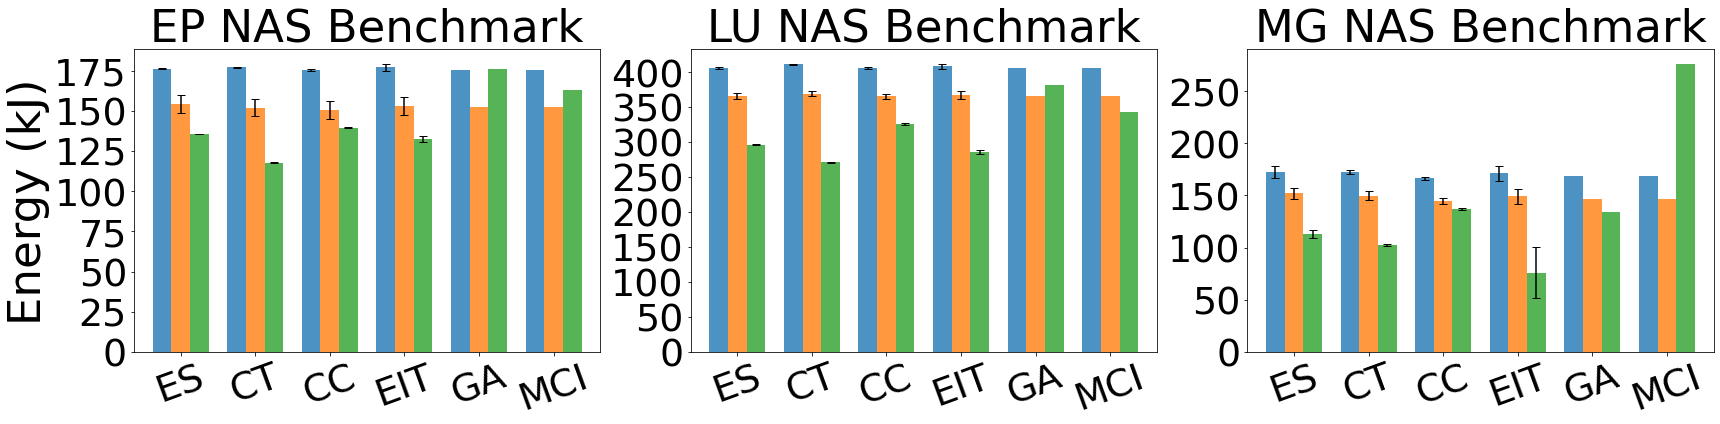

In [33]:
bar_plot(concated_df, new_cols, group_by_cols)

This graphs was used in the paper. All comments are made there.